In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

sns.set_theme(style="ticks")

In [3]:
# Use raw string or double backslashes for the path
path = r"E:\Github\White-Blood-cell-\bloodcells_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Check if the directory exists
if not os.path.exists(path):
    print(f"Directory {path} does not exist.")
else:
    dataset, test_dataset = keras.utils.image_dataset_from_directory(
        directory=path,
        image_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        label_mode="int",
        validation_split=0.2,
        subset="both",
        shuffle=True,
        seed=42
    )

    # Get class names
    class_names = dataset.class_names
    print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


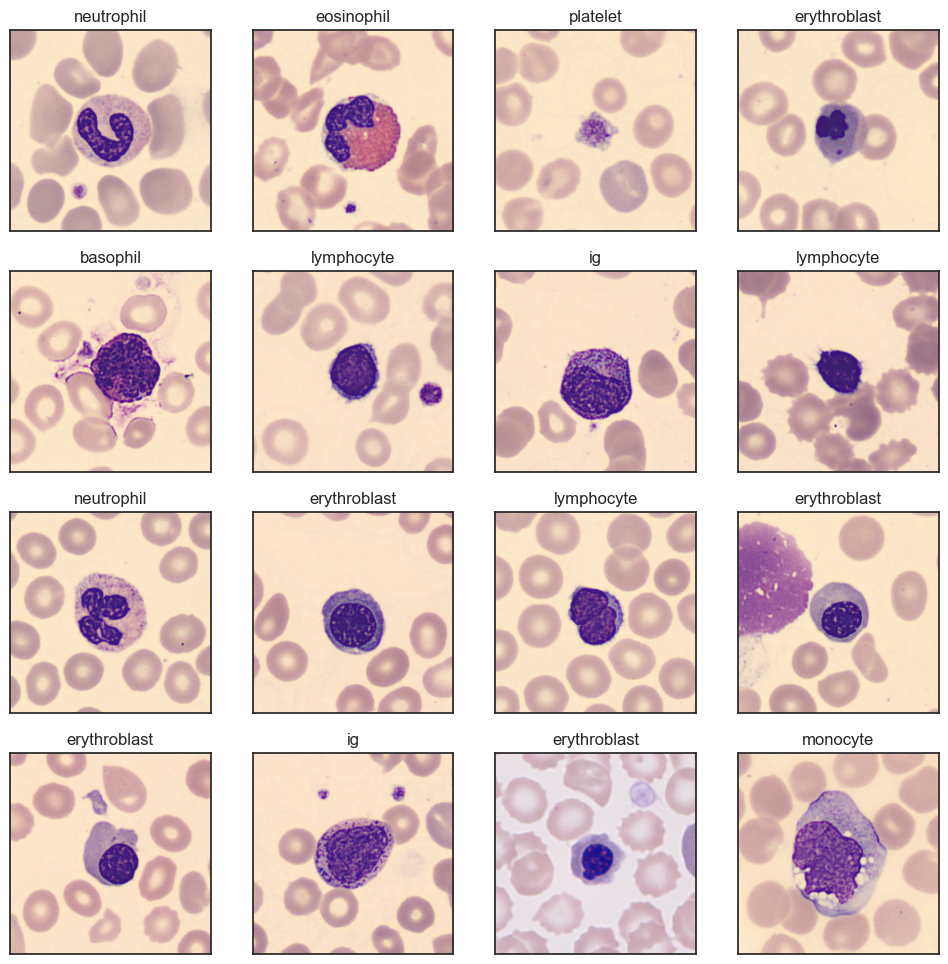

In [4]:
# Plot 16 images from the dataset as examples
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(16):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

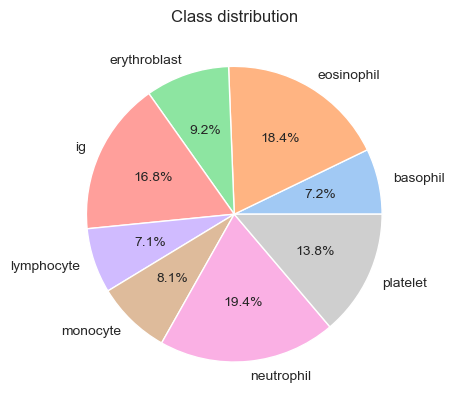

In [5]:
# Check if classes are balanced
labels = np.concatenate([label for image, label in dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.show()

In [6]:
# Split dataset in train and validation set
num_elements = len(dataset)
train_size = int(0.8 * num_elements)
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check length
len(train_dataset), len(val_dataset), len(test_dataset)

(342, 86, 107)

In [7]:
# Check format
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [8]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(3.4720578, shape=(), dtype=float32)


## Model 1 (Baseline DNN)

Consists of a rescaling layer, a flattening layer, 5 hidden dense layer with 128 neurons and a ReLU activation function, and an output layer with 8 neurons and a softmax activation function.

In [9]:
# Create a lab-book to track the different experiments
lab_book = {}

# Create early stopping callback
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [13]:
# Lab book name entry
name = "DNN"

# Build model
tf.random.set_seed(42)
model_1 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(8, activation="softmax")
], name=name)

model_1.summary()

Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,334,792 (73.76 MB)

 Trainable params: 19,334,792 (73.76 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#  Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

In [15]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.2107 - loss: 31.2846 - val_accuracy: 0.3872 - val_loss: 1.5332
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - accuracy: 0.5062 - loss: 1.3849 - val_accuracy: 0.5392 - val_loss: 1.2135
Epoch 3/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 76s 221ms/step - accuracy: 0.5356 - loss: 1.2464 - val_accuracy: 0.5821 - val_loss: 1.2296
Epoch 4/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 73s 214ms/step - accuracy: 0.5657 - loss: 1.1302 - val_accuracy: 0.6560 - val_loss: 0.9070
Epoch 5/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - accuracy: 0.6424 - loss: 0.9421 - val_accuracy: 0.5681 - val_loss: 1.2071
Epoch 6/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 70s 205ms/step - accuracy: 0.6015 - loss: 1.0470 - val_accuracy: 0.6777 - val_loss: 0.8903
Epoch 7/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 70s 204ms/step - accuracy: 0.5997 - loss: 1.0509 - val_accuracy: 0.4960 - val_loss: 1.2366
Epoch 8/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 203ms/step - accuracy: 0.6016 - loss: 

In [61]:
# Write lab-book
train_loss, train_accuracy = model_1.evaluate(train_dataset)
val_accuracy = model_1.evaluate(val_dataset)
lab_book[name] = {"train_accuracy": train_accuracy,"train_loss": train_loss, "val_accuracy": val_accuracy}

342/342 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6792 - loss: 0.7952
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6789 - loss: 0.8201


In [62]:
train_accuracy

0.6843932867050171

In [63]:
train_loss

0.7867207527160645

In [64]:
val_accuracy

[0.798754870891571, 0.6853479743003845]

In [153]:
# Evaluate the model on the test dataset and get predictions
test_loss, test_accuracy = model_1.evaluate(test_dataset)
predictions = model_1.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming your test_dataset is a tf.data.Dataset and you have the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6669 - loss: 0.8256
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [154]:
test_loss

0.8094488382339478

In [155]:
test_accuracy

0.6755412817001343

In [156]:
predictions

array([[4.9080711e-04, 8.9423132e-01, 1.1240877e-03, ..., 1.7975133e-02,
        6.3220374e-02, 1.8521880e-05],
       [5.2260091e-03, 7.1148121e-01, 2.7934560e-03, ..., 5.8096021e-02,
        1.3059905e-01, 3.1057596e-05],
       [3.6015420e-03, 1.3827228e-04, 6.8242222e-01, ..., 6.1360362e-05,
        3.2036409e-03, 2.1325704e-04],
       ...,
       [1.0870390e-02, 3.0852921e-04, 5.2474159e-01, ..., 1.1950074e-04,
        3.7716106e-03, 2.3905266e-04],
       [9.1290094e-02, 7.3281028e-03, 2.3029760e-01, ..., 4.8031722e-04,
        1.3178639e-02, 8.1086393e-05],
       [1.3527618e-07, 7.5209260e-05, 8.8594249e-03, ..., 2.0890137e-05,
        3.7953334e-05, 9.9088669e-01]], dtype=float32)

In [157]:
predicted_labels

array([1, 1, 2, ..., 2, 4, 7], dtype=int64)

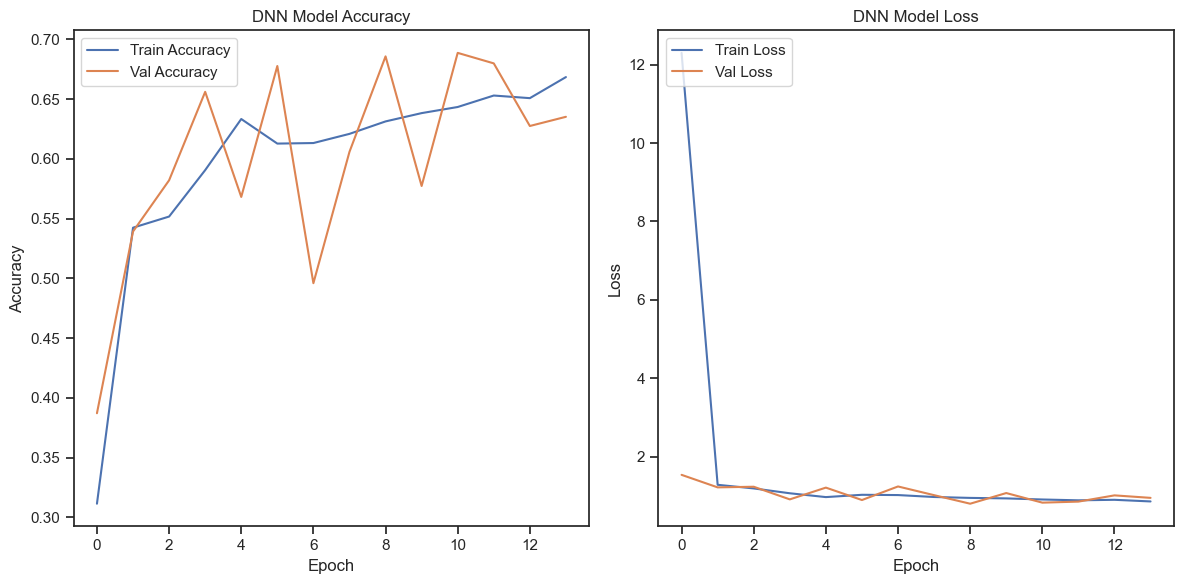

In [70]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.title('DNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.title('DNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Model 2 (Simple CNN)

Consists of a rescaling layer followed by a Conv2D layer with 8 filters and a MaxPool2D layer, a flattening layer and the standard output layer.

In [20]:
# Lab book name entry
name = "CNN"

# Build model
tf.random.set_seed(42)
model_2 = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model_2.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile model
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
# Fit model
history_2 = model_2.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.3939 - loss: 8.4663 - val_accuracy: 0.7586 - val_loss: 0.7612
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - accuracy: 0.8047 - loss: 0.5732 - val_accuracy: 0.8579 - val_loss: 0.4364
Epoch 3/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.9042 - loss: 0.3038 - val_accuracy: 0.8626 - val_loss: 0.4254
Epoch 4/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.9389 - loss: 0.2112 - val_accuracy: 0.8729 - val_loss: 0.3902
Epoch 5/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.9592 - loss: 0.1425 - val_accuracy: 0.8846 - val_loss: 0.3690
Epoch 6/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.9699 - loss: 0.1160 - val_accuracy: 0.8516 - val_loss: 0.4911
Epoch 7/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.9751 - loss: 0.0928 - val_accuracy: 0.8821 - val_loss: 0.3997
Epoch 8/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - accuracy: 0.9862 - loss: 0.

In [75]:
# Write lab-book
train_loss_2, train_accuracy_2 = model_2.evaluate(train_dataset)
val_accuracy_2 = model_2.evaluate(val_dataset)
lab_book[name] = {"train_accuracy": train_accuracy_2,"train_loss_2": train_loss_2, "val_accuracy_2": val_accuracy_2}

342/342 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9759 - loss: 0.0998
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9032 - loss: 0.3098


In [76]:
train_accuracy_2

0.9818165302276611

In [77]:
train_loss_2

0.0881526917219162

In [78]:
val_accuracy_2

[0.36491015553474426, 0.8860805630683899]

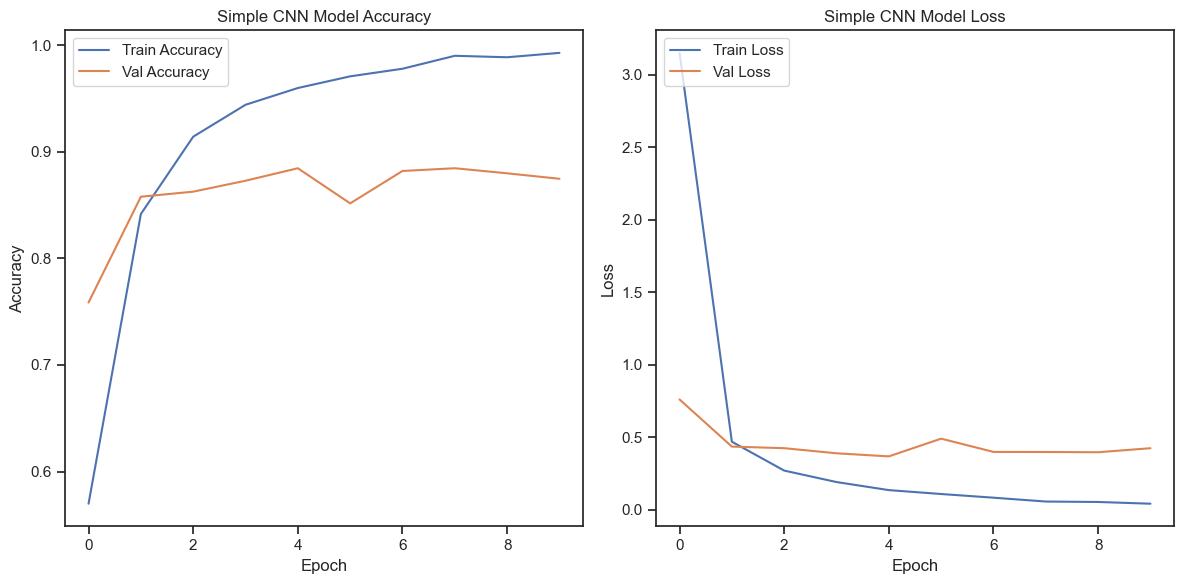

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Simple CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title('Simple CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
# Evaluate the model on the test dataset and get predictions
test_loss, test_accuracy = model_2.evaluate(test_dataset)
predictions = model_2.predict(test_dataset)
predictions_labels = np.argmax(predictions, axis=1)

# # Assuming your test_dataset is a tf.data.Dataset and you have the true labels
# true_labels_1 = np.concatenate([y for x, y in test_dataset], axis=0)

107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8755 - loss: 0.3834
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


In [45]:
test_loss

0.3738994300365448

In [46]:
test_accuracy

0.8724400401115417

In [47]:
predictions

array([1, 1, 4, ..., 2, 4, 7], dtype=int64)

In [ ]:
predictions_labels

**Conclusion:**

* The simple CNN model is highly overfitting. Therefore, data augmentation is implemented.

In [90]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [91]:
# Define image dimensions and other parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224  # EfficientNetB0 expects 224x224 images

# Lab book name entry
name = "VGG16"

tf.random.set_seed(42)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model


In [92]:
model_3 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
], name="VGG16_Model")

model_3.summary()

Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 8)                   │         200,712 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,915,400 (56.90 MB)

 Trainable params: 200,712 (784.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [93]:
# Compile model
model_3.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [94]:
# Fit model
history_3 = model_3.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2514s 7s/step - accuracy: 0.6689 - loss: 1.0669 - val_accuracy: 0.9040 - val_loss: 0.2923
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2425s 7s/step - accuracy: 0.9235 - loss: 0.2439 - val_accuracy: 0.9264 - val_loss: 0.2228
Epoch 3/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3299s 10s/step - accuracy: 0.9544 - loss: 0.1509 - val_accuracy: 0.9341 - val_loss: 0.2031
Epoch 4/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3311s 10s/step - accuracy: 0.9723 - loss: 0.0993 - val_accuracy: 0.9374 - val_loss: 0.1944
Epoch 5/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2934s 9s/step - accuracy: 0.9834 - loss: 0.0678 - val_accuracy: 0.9278 - val_loss: 0.2071
Epoch 6/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2879s 8s/step - accuracy: 0.9871 - loss: 0.0576 - val_accuracy: 0.9242 - val_loss: 0.2166
Epoch 7/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3091s 9s/step - accuracy: 0.9901 - loss: 0.0429 - val_accuracy: 0.9476 - val_loss: 0.1659
Epoch 8/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2777s 8s/step - accuracy: 0.9947 - loss: 0.0305 

In [95]:
# Write lab-book
train_loss_3, train_accuracy_3 = model_3.evaluate(train_dataset)
val_accuracy_3 = model_3.evaluate(val_dataset)
lab_book[name] = {"train_accuracy_3": train_accuracy_3,"train_loss_3": train_loss_3, "val_accuracy_3": val_accuracy_3}

342/342 ━━━━━━━━━━━━━━━━━━━━ 1733s 5s/step - accuracy: 0.9979 - loss: 0.0205
86/86 ━━━━━━━━━━━━━━━━━━━━ 574s 7s/step - accuracy: 0.9537 - loss: 0.1456


In [96]:
train_loss_3

0.018575817346572876

In [97]:
train_accuracy_3

0.9987207651138306

In [98]:
val_accuracy_3

[0.16715654730796814, 0.946886420249939]

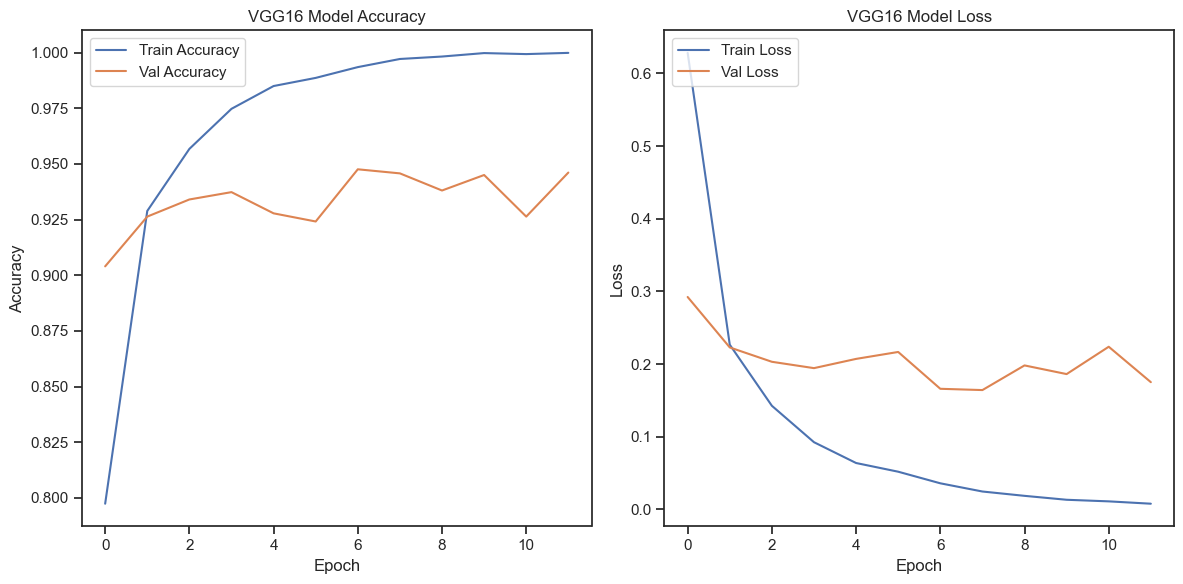

In [99]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [100]:
# Evaluate the model on the test dataset and get predictions
test_loss_3, test_accuracy_3 = model_3.evaluate(test_dataset)
predictions_3 = model_3.predict(test_dataset)
predictions_labels_3 = np.argmax(predictions, axis=1)


107/107 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.9344 - loss: 0.2019
107/107 ━━━━━━━━━━━━━━━━━━━━ 541s 5s/step


In [101]:
test_loss_3

0.19884967803955078

In [102]:
test_accuracy_3

0.9341720342636108

In [103]:
predictions_3

array([[8.07171716e-07, 9.99931812e-01, 4.35450120e-09, ...,
        2.64945788e-06, 6.37272242e-05, 6.37898415e-11],
       [5.10787181e-08, 9.98349667e-01, 6.08653750e-07, ...,
        1.01524885e-04, 1.43284525e-03, 6.33515351e-10],
       [3.57234734e-03, 9.65960935e-05, 3.47754941e-03, ...,
        4.20627839e-05, 1.51786255e-04, 3.11991330e-02],
       ...,
       [1.22087840e-07, 2.67530368e-07, 9.99833703e-01, ...,
        7.86522492e-09, 5.22321061e-05, 2.65990479e-07],
       [9.84787643e-01, 5.64864604e-03, 6.38908314e-05, ...,
        2.60082516e-03, 6.93685259e-04, 9.66279476e-04],
       [8.49350326e-05, 5.84113286e-06, 1.27353720e-04, ...,
        1.01673650e-05, 7.97429093e-05, 9.99297261e-01]], dtype=float32)

In [104]:
predictions_labels_3

array([1, 1, 2, ..., 2, 4, 7], dtype=int64)

In [105]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19

In [106]:
# Lab book name entry
name = "VGG19"

tf.random.set_seed(42)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model

In [107]:
model_4 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    base_model,
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
], name=name)

model_4.summary()

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 8)                   │         200,712 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,915,400 (56.90 MB)

 Trainable params: 200,712 (784.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [108]:
# Compile model
model_4.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [109]:
# Fit model
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 2210s 6s/step - accuracy: 0.6803 - loss: 0.9820 - val_accuracy: 0.8799 - val_loss: 0.3570
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3048s 9s/step - accuracy: 0.9185 - loss: 0.2631 - val_accuracy: 0.9205 - val_loss: 0.2398
Epoch 3/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3036s 9s/step - accuracy: 0.9588 - loss: 0.1452 - val_accuracy: 0.9179 - val_loss: 0.2415
Epoch 4/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3005s 9s/step - accuracy: 0.9665 - loss: 0.1154 - val_accuracy: 0.9198 - val_loss: 0.2484
Epoch 5/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 3043s 9s/step - accuracy: 0.9778 - loss: 0.0828 - val_accuracy: 0.9410 - val_loss: 0.1730


In [110]:
# Write lab-book
train_loss_4, train_accuracy_4 = model_4.evaluate(train_dataset)
val_accuracy_4 = model_4.evaluate(val_dataset)
lab_book[name] = {"train_accuracy_4": train_accuracy_4,"train_loss_4": train_loss_4, "val_accuracy_4": val_accuracy_4}

342/342 ━━━━━━━━━━━━━━━━━━━━ 1812s 5s/step - accuracy: 0.9035 - loss: 0.2998
86/86 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.8832 - loss: 0.3425


In [111]:
train_loss_4

0.2877272665500641

In [112]:
train_accuracy_4

0.9067068696022034

In [113]:
val_accuracy_4

[0.35961633920669556, 0.8776556849479675]

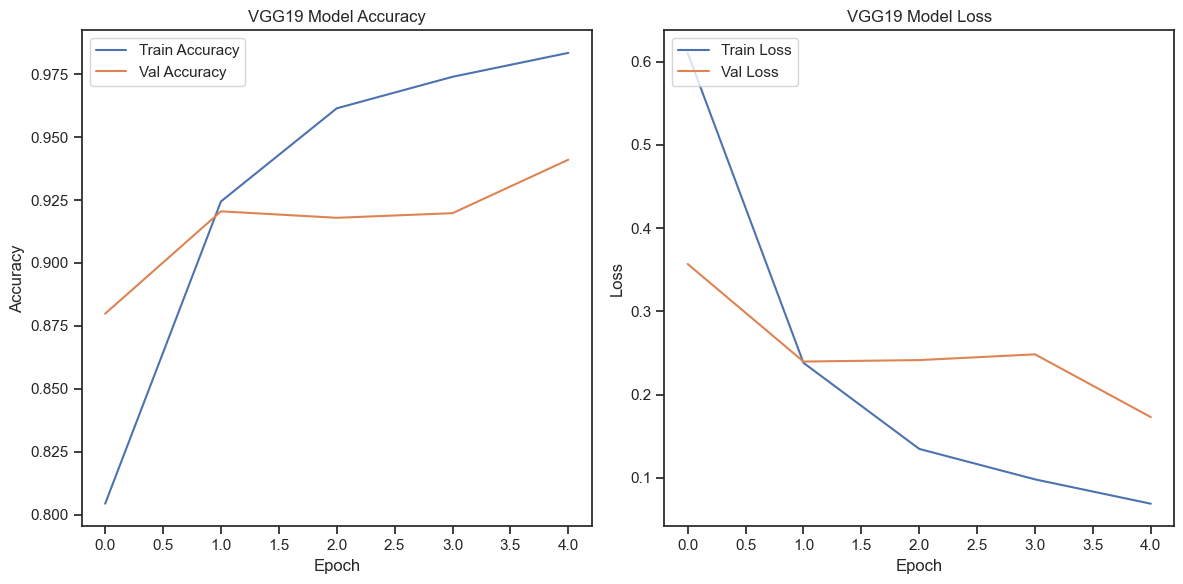

In [114]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.title('VGG19 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [115]:
# Evaluate the model on the test dataset and get predictions
test_loss_4, test_accuracy_4 = model_4.evaluate(test_dataset)
predictions_4 = model_4.predict(test_dataset)
predictions_labels_4 = np.argmax(predictions, axis=1)


107/107 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.8702 - loss: 0.3997
107/107 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step


In [116]:
test_loss_4

0.39822083711624146

In [117]:
test_accuracy_4

0.8692217469215393

In [118]:
predictions_4

array([[7.5252290e-05, 9.8891246e-01, 7.0515257e-06, ..., 4.4151890e-05,
        1.0203545e-02, 3.2734602e-07],
       [8.8648248e-06, 9.6956575e-01, 5.0973715e-05, ..., 1.7788098e-04,
        2.8217215e-02, 9.3951837e-07],
       [8.2348892e-03, 4.6967370e-03, 1.0777527e-02, ..., 3.5733785e-04,
        3.8421468e-03, 3.9420281e-02],
       ...,
       [4.2810648e-06, 1.9255903e-04, 9.8606968e-01, ..., 5.2149949e-06,
        4.8637288e-03, 2.2568494e-04],
       [6.6232806e-01, 9.8081633e-02, 1.0337585e-03, ..., 1.5442302e-03,
        5.9843149e-02, 8.9241089e-03],
       [1.3795447e-03, 2.9166506e-03, 8.2501961e-04, ..., 2.6507847e-04,
        1.7616967e-02, 9.5947230e-01]], dtype=float32)

In [119]:
predictions_labels_4

array([1, 1, 2, ..., 2, 4, 7], dtype=int64)

## Model 5 (ResNet50)


In [122]:
from tensorflow.keras import layers, models

In [123]:
# Lab book name entry
name = "ResNet50"

# Build the ResNet50 model
tf.random.set_seed(42)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model


In [129]:
model_5 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(8, activation="softmax")
], name=name)

model_5.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 8)                   │          16,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [130]:
# Compile model
model_5.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [131]:
# Fit model
history_5 = model_5.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25,
                        callbacks=[early_cb])

Epoch 1/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - accuracy: 0.2161 - loss: 2.0071 - val_accuracy: 0.3938 - val_loss: 1.8638
Epoch 2/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 876s 3s/step - accuracy: 0.3389 - loss: 1.8665 - val_accuracy: 0.4004 - val_loss: 1.7681
Epoch 3/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - accuracy: 0.4048 - loss: 1.7662 - val_accuracy: 0.4055 - val_loss: 1.6840
Epoch 4/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 950s 3s/step - accuracy: 0.4464 - loss: 1.6847 - val_accuracy: 0.4755 - val_loss: 1.6219
Epoch 5/25
342/342 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.4568 - loss: 1.6289 - val_accuracy: 0.4593 - val_loss: 1.5664


In [133]:
# Write lab-book
train_loss_5, train_accuracy_5 = model_5.evaluate(train_dataset)
val_accuracy_5 = model_5.evaluate(val_dataset)
lab_book[name] = {"train_accuracy_5": train_accuracy_5,"train_loss_5": train_loss_5, "val_accuracy_5": val_accuracy_5}

342/342 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.3787 - loss: 1.8827
86/86 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3920 - loss: 1.8668


In [134]:
train_loss_5

1.883332371711731

In [135]:
train_accuracy_5

0.3777412176132202

In [136]:
val_accuracy_5

[1.8652671575546265, 0.3937729001045227]

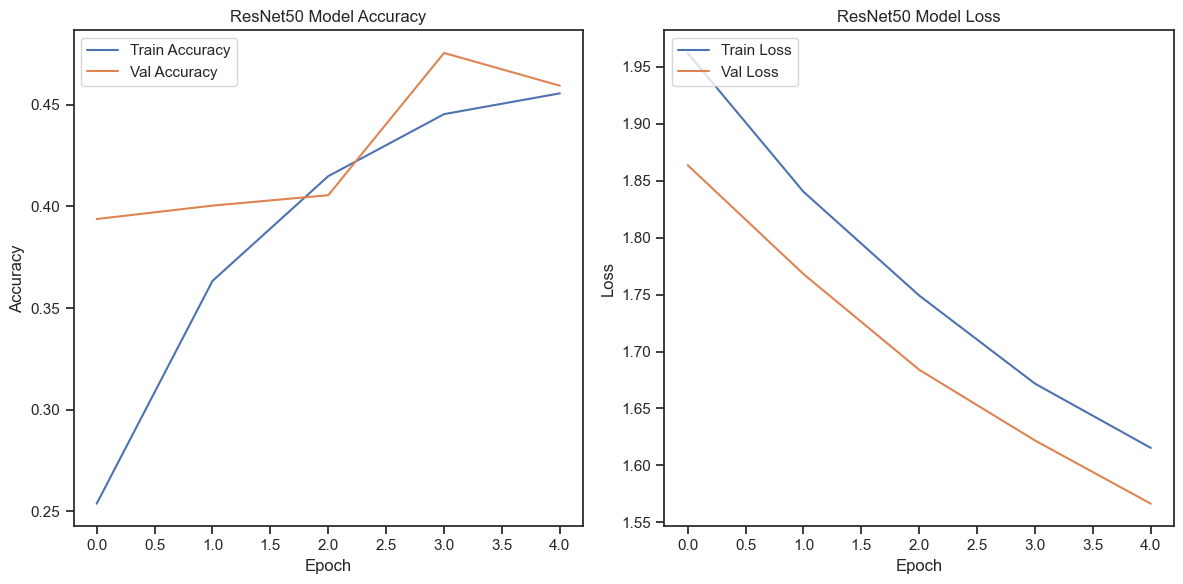

In [137]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [138]:
# Evaluate the model on the test dataset and get predictions
test_loss_5, test_accuracy_5 = model_5.evaluate(test_dataset)
predictions_5 = model_5.predict(test_dataset)
predictions_labels_5 = np.argmax(predictions, axis=1)


107/107 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.3546 - loss: 1.9001
107/107 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step


In [139]:
test_loss_5

1.8870887756347656

In [140]:
test_accuracy_5

0.3683440685272217

In [141]:
predictions_5

array([[0.07691432, 0.20405307, 0.12067167, ..., 0.06119241, 0.19346218,
        0.1241828 ],
       [0.08244002, 0.22286257, 0.10465309, ..., 0.06036513, 0.21481009,
        0.09052115],
       [0.08053486, 0.19199716, 0.11564891, ..., 0.05133   , 0.25563192,
        0.09443487],
       ...,
       [0.0728466 , 0.18884557, 0.13013943, ..., 0.05988681, 0.19415651,
        0.13705409],
       [0.08565369, 0.20195252, 0.11114745, ..., 0.05404018, 0.2380661 ,
        0.0905394 ],
       [0.07079081, 0.18805538, 0.12768906, ..., 0.06057667, 0.1751005 ,
        0.15459564]], dtype=float32)

In [142]:
predictions_labels_5

array([1, 1, 2, ..., 2, 4, 7], dtype=int64)

**Conclusion**:

* Incredible performance of approximately 98.6% accuracy on the validation set.

## Test all models on the test set

In [159]:
# Test models on respective test sets
model_list = [model_1, model_2, model_3, model_4, model_5]
for counter, model in enumerate(model_list):
  if model != model_5:
    score = model.evaluate(test_dataset, verbose=0)[1]
    print(f"Model {counter+1}: {score:.2f}")
    # test_scores["Model_"+str(counter+1)] = score
  else:
    score = model.evaluate(test_dataset_resnet, verbose=0)[1]
    print(f"Model 5: {score:.2f}")
    # test_scores["Model_5"] = score

Model 1: 0.68
Model 2: 0.87
Model 3: 0.93
Model 4: 0.87
Model 5: 0.37


**Conclusion:**

- The test set represents the overall data very well, as evidenced by the very small differences in accuracy between the validation and test sets.
- Model 3 performs best with a test set accuracy of 94%.

## Examine the errors of Model 3 on the test data


In [160]:
# Storage lists for predictions, probabilities and true labels
y_pred = []
y_pred_proba = []
y_true = []


# Iterate over the dataset
for image_batch, label_batch in test_dataset_resnet:
   y_true.append(label_batch)
   preds = model_3.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

# Concatenate and convert correct and predicted labels
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

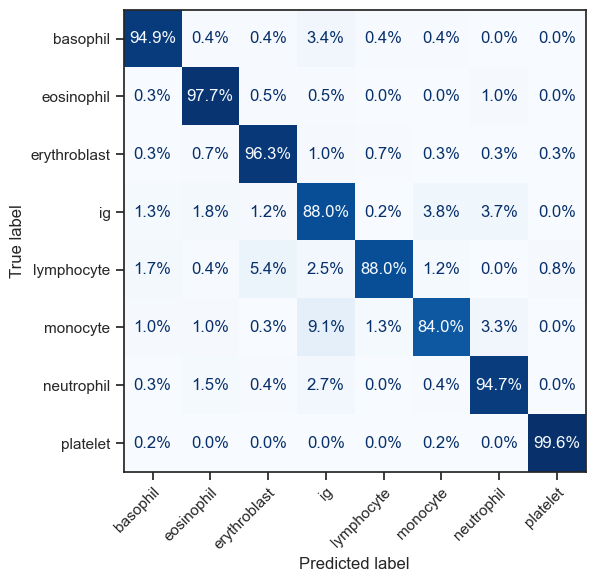

In [161]:
# Check confusion matrix of model 6
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

**Conclusion:**

- The various class accuracies range from 96.3% (ig) to 100.0% (erythroblast).

**Take a look at the most common mistakes.**

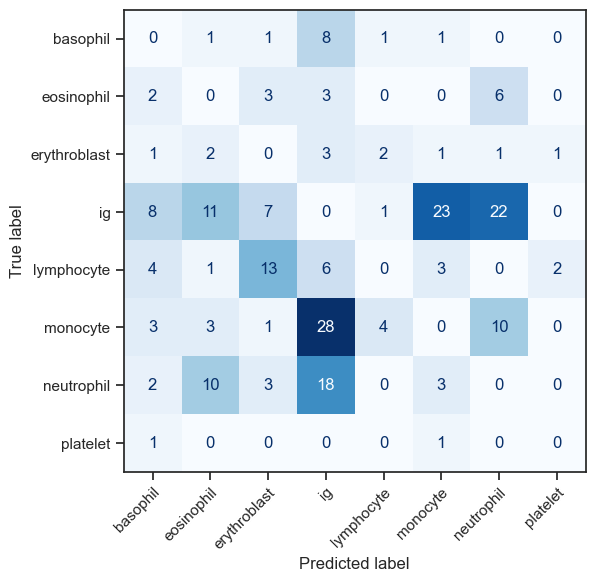

In [162]:
# Plot confusion matrix with zero weigth in the correct predictions
sample_weight = (correct_labels != predicted_labels)
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        cmap="Blues",
                                        sample_weight=sample_weight,
                                        ax=axes,
                                        colorbar=False)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

The **3 most common mistakes** are:
* Mistaking ig for beeing neutrophil (16)
* Mistaking monocyte for beeing ig (7)
* Mistaken neutrophile for beeing ig (7)

In [163]:
# Print classification report
print(
    "Classification report rebuilt from confusion matrix:\n"
    f"{classification_report(y_true=correct_labels, y_pred=predicted_labels, target_names=class_names)}\n"
)

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

    basophil       0.91      0.95      0.93       237
  eosinophil       0.95      0.98      0.97       596
erythroblast       0.91      0.96      0.94       294
          ig       0.89      0.88      0.88       602
  lymphocyte       0.96      0.88      0.92       241
    monocyte       0.89      0.84      0.86       307
  neutrophil       0.94      0.95      0.94       679
    platelet       0.99      1.00      0.99       462

    accuracy                           0.93      3418
   macro avg       0.93      0.93      0.93      3418
weighted avg       0.93      0.93      0.93      3418




**Conclusion:**
- $F_1$ scores range from 0.99 for most classes to 0.97 (ig).

**Collect 40 wrongly predicted images to investigate the reasons.**

In [164]:
# Check predictions and store them in arrays
y_true = []
y_pred = []
images = []
for image, label in test_dataset.unbatch():
  # Reshape for model compatibility
  image_reshaped = tf.reshape(image, shape=(1,224,224,3))
  # Preprocess for resnet
  image_processed = preprocess_input(image_reshaped)
  # Predict most likely class
  prediction = model_3.predict(image_processed, verbose=0)
  prediction = np.argmax(prediction, axis=-1)
  # Check if prediction and true label are not equal
  if prediction != label:
    images.append(image / 255.)
    y_pred.append(prediction)
    y_true.append(label)

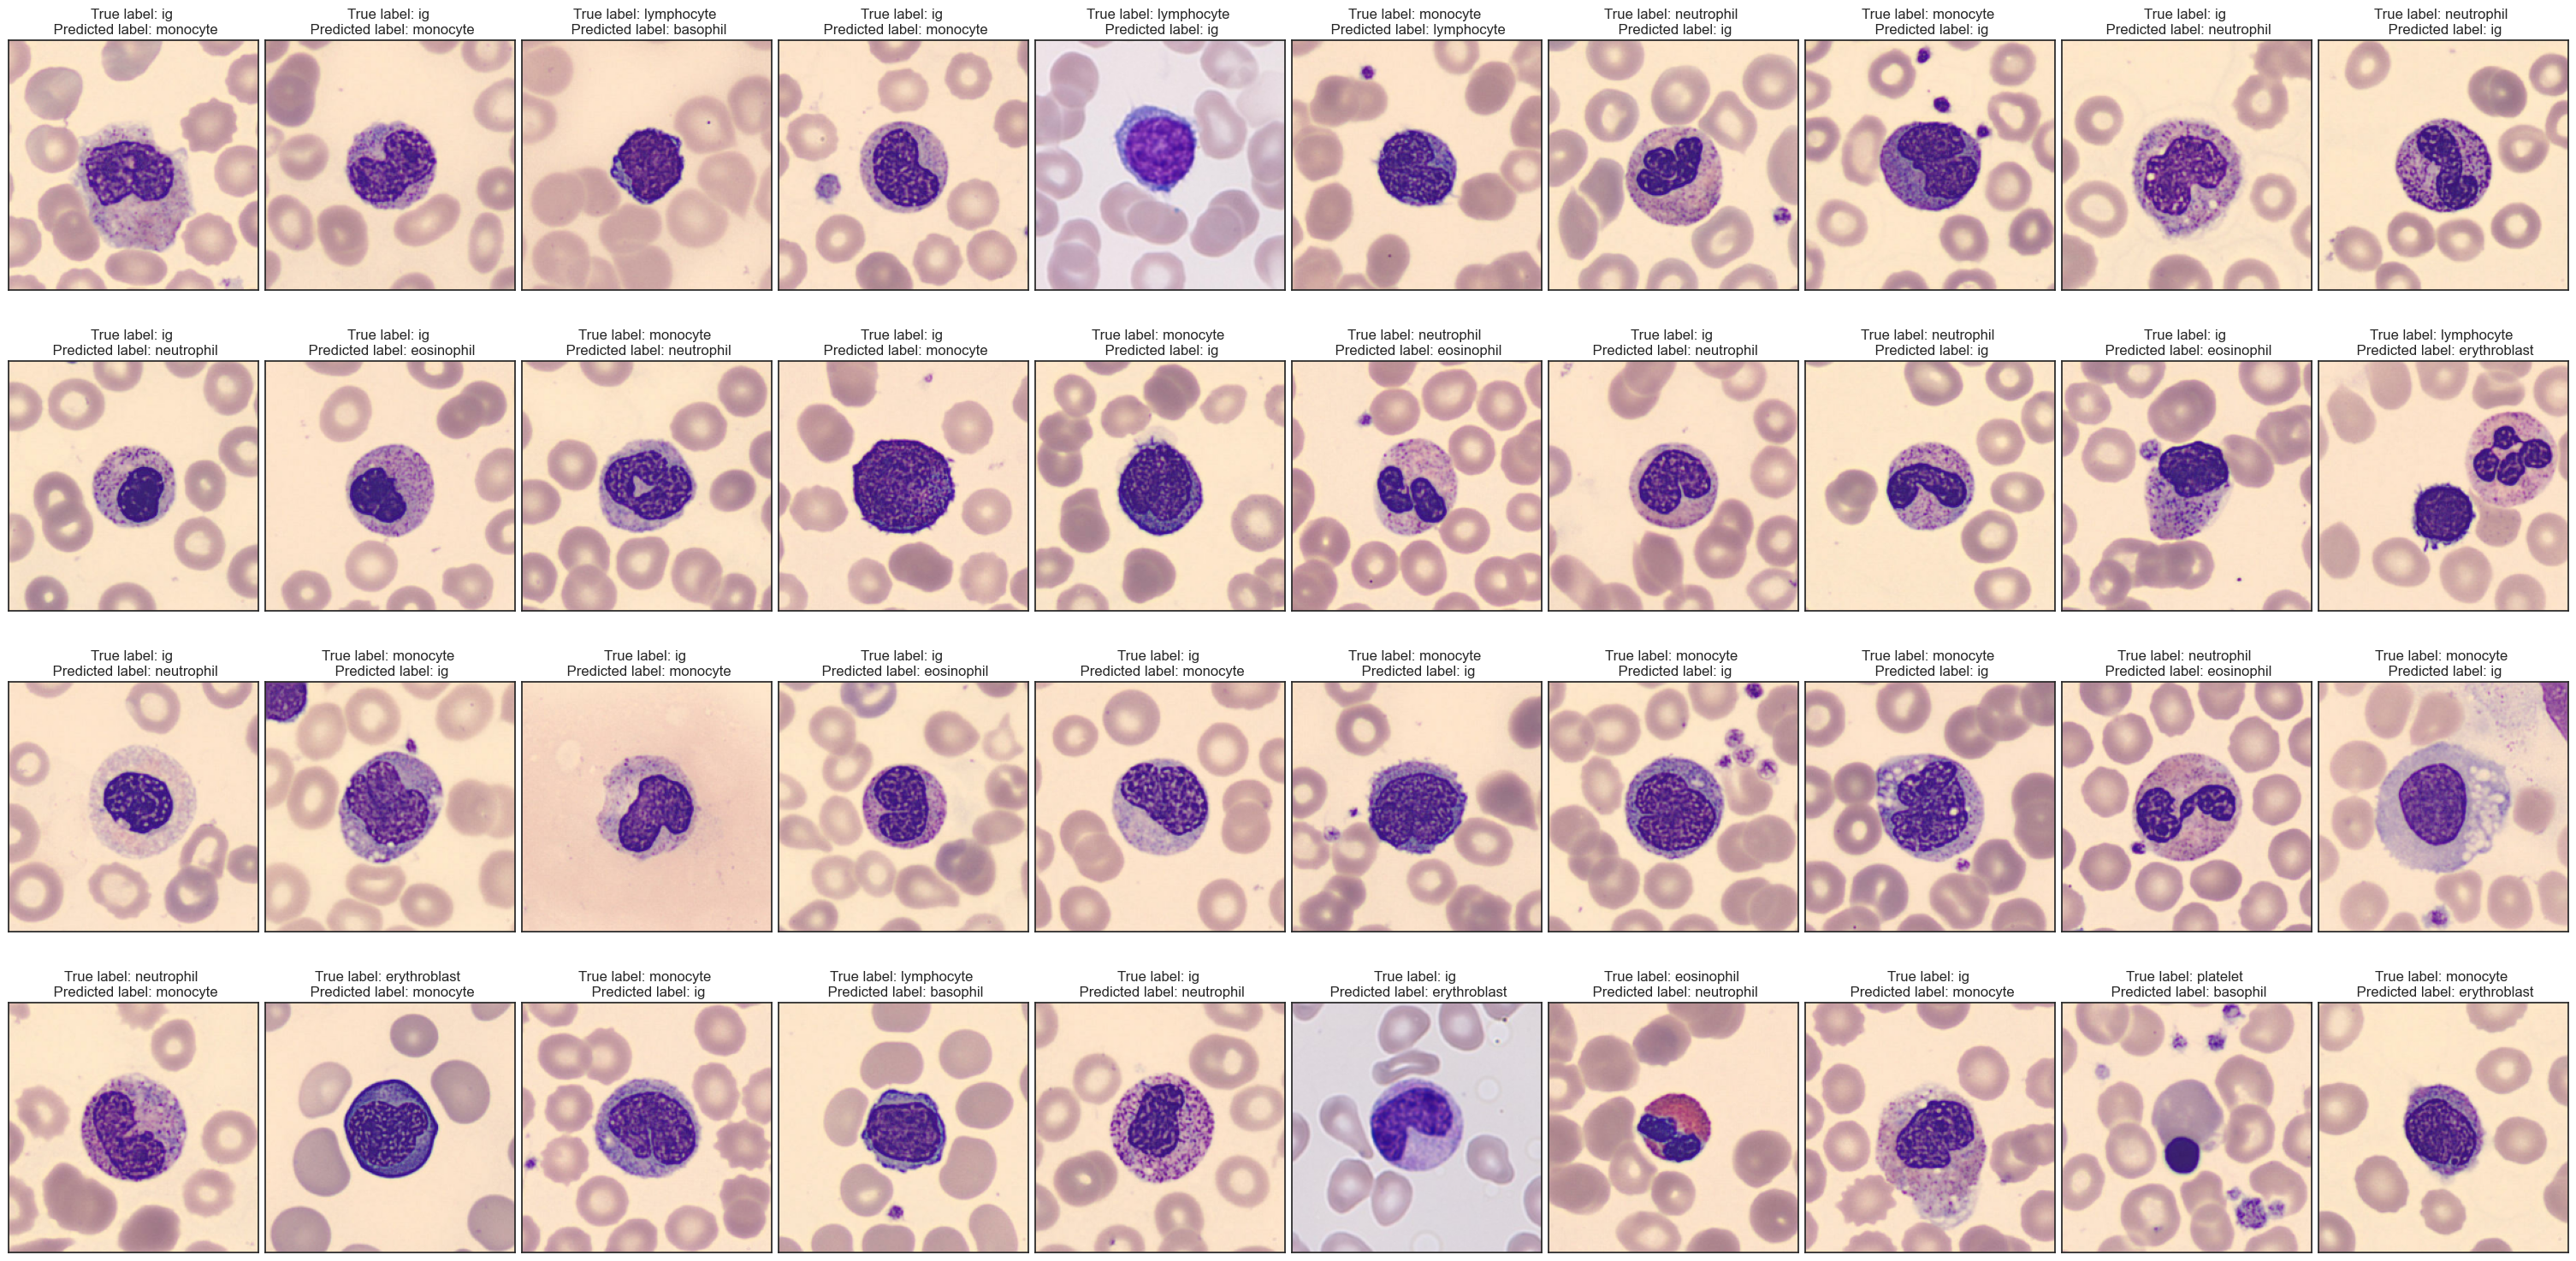

In [165]:
# Plot 60 wrongly predicted images
fig, axes = plt.subplots(4, 10, figsize=(30,15), layout="constrained")
for counter, axis in enumerate(axes.flatten()):
  axis.imshow(images[counter])
  axis.set_title(f"True label: {class_names[y_true[counter].numpy()]} \n Predicted label: {class_names[y_pred[counter].item()]}")
  axis.set_xticks([])
  axis.set_yticks([])
plt.show()

## Performance trajectory

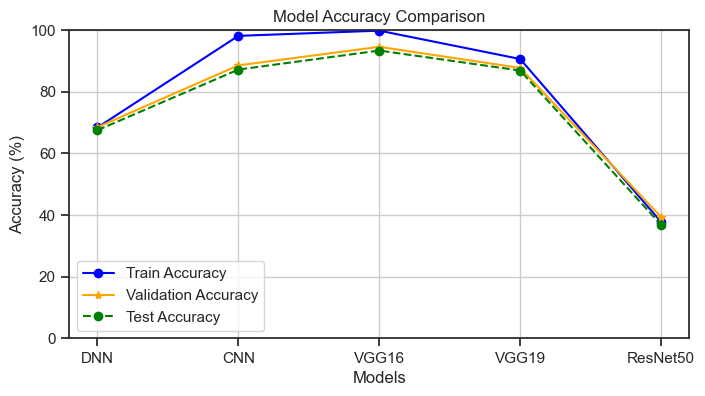

In [196]:
import matplotlib.pyplot as plt

# Accuracy values
train_accuracy = [68.43, 98.18, 99.87, 90.67, 37.77]
validation_accuracy = [68.53, 88.60, 94.62, 87.76, 39.37]
test_accuracy = [67.55, 87.24, 93.41, 86.92, 36.83]

# Model labels
labels = ['DNN', 'CNN', 'VGG16', 'VGG19', 'ResNet50']

# Plotting the results
plt.figure(figsize=(8, 4))

plt.plot(labels, train_accuracy, marker='o', label='Train Accuracy', color='blue')
plt.plot(labels, validation_accuracy, marker='*', label='Validation Accuracy', color='orange')
plt.plot(labels, test_accuracy, 'o--', label='Test Accuracy', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.show()
